## SMS Spam Detection
- โหลดและทำความสะอาดชุดข้อมูลสแปม SMS และเข้ารหัสป้ายกำกับให้อยู่ในรูปแบบตัวเลข
- เตรียมสถิติข้อความและขั้นตอนการแปลงข้อความให้เป็นเวกเตอร์สำหรับโมเดลการเรียนรู้เชิงลึก
- สร้างโมเดล TensorFlow สามโมเดล ได้แก่ โมเดลฝังข้อมูลแบบหนาแน่น (dense embedding model), โมเดล Bi-LSTMและโมเดลการเรียนรู้แบบถ่ายโอนโดยใช้ Universal Sentence Encoder (USE)
- ฝึกฝนโมเดลทั้งหมดโดยใช้ไปป์ไลน์ตัวช่วยร่วมกัน และประเมินผลโดยใช้ความถูกต้องแม่นยำ ความเที่ยงตรง การเรียกคืน และคะแนน F1
- แสดงภาพประสิทธิภาพของโมเดลโดยใช้แผนภูมิแท่งและแผนภูมิเส้นเพื่อเปรียบเทียบตัวชี้วัดต่างๆ

### 1. Import Dependencies

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow_hub as hub

### 2. Load Data

In [2]:
df = pd.read_csv('spam.csv')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### 3. Clean Data

In [3]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


### 4. Split Data and Convert to Numpy Array

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label_enc'],
    test_size=0.2, random_state=42
)

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

### 5. Compute Text Statistic for Vectorization

- คำนวณจำนวนคำเฉลี่ยต่อข้อความ SMS ซึ่งใช้เป็นความยาวลำดับสำหรับการเติมคำ (padding)
- ประเมินขนาดของคำศัพท์โดยการนับจำนวนโทเค็นที่ไม่ซ้ำกันในข้อความทั้งหมด
- แสดงสถิติพื้นฐานของชุดข้อมูลเพื่อใช้เป็นข้อมูลอ้างอิง

In [6]:

avg_word_len = round(sum([len(i.split()) for i in df['text']]) / len(df['text']))

total_words_length = len(set(" ".join(df['text']).split()))

print(f'Data Loaded. Training samples: {len(X_train_np)}')
print(f'Average words per message: {avg_word_len}')
print(f'Approximate vocabulary size: {total_words_length}')

Data Loaded. Training samples: 4457
Average words per message: 16
Approximate vocabulary size: 15686


### 6. Helper function for training and evaluation
- compile_and_fit ทำหน้าที่รวมศูนย์ตรรกะการคอมไพล์และการฝึกฝนสำหรับทุกโมเดล
- ใช้ binary_crossentropy และ accuracy สำหรับการจำแนกแบบไบนารี
- ฝึกฝนโมเดลด้วยข้อมูลฝึกฝนและตรวจสอบความถูกต้องด้วยข้อมูลทดสอบ โดยส่งคืนประวัติการฝึกฝน
- get_metrics ทำนายป้ายกำกับ ปัดเศษความน่าจะเป็นเป็น 0 หรือ 1 และคำนวณความแม่นยำ ความเที่ยงตรง การเรียกคืน และคะแนน F1

In [7]:
def compile_and_fit(model, epochs=5):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        X_train_np,
        y_train_np,
        epochs=epochs,
        validation_data=(X_test_np, y_test_np)
    )
    return history

def get_metrics(model, X, y):
    y_preds = np.round(model.predict(X))
    return {
        'accuracy': accuracy_score(y, y_preds),
        'precision': precision_score(y, y_preds),
        'recall': recall_score(y, y_preds),
        'f1_score': f1_score(y, y_preds)
    }

### 7. Create TextVectorization layer
- สร้างเลเยอร์ TextVectorization เพื่อแปลงข้อความดิบให้เป็นลำดับตัวเลขจำนวนเต็ม
- จำกัดขนาดคำศัพท์ให้มีจำนวนคำที่ไม่ซ้ำกันเท่ากับ total_words_length
- ปรับรูปแบบข้อความให้เป็นมาตรฐานโดยการแปลงเป็นตัวพิมพ์เล็กและลบเครื่องหมายวรรคตอนออก
- เพิ่มหรือตัดทอนลำดับแต่ละลำดับให้เหลือโทเค็นตามจำนวนคำเฉลี่ย (avg_words_len)
- ปรับเลเยอร์ให้เข้ากับข้อมูลฝึกฝนเพื่อเรียนรู้การกระจายตัวของคำศัพท์


In [ ]:
from keras.layers import TextVectorization
text_vec = TextVectorization(
    max_tokens=total_words_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=avg_word_len
)
text_vec.adapt(X_train_np)

array([[4683,    0,    0, ...,    0,    0,    0],
       [6538,    0,    0, ...,    0,    0,    0],
       [6538,    0,    0, ...,    0,    0,    0],
       ...,
       [6538,    0,    0, ...,    0,    0,    0],
       [6538,    0,    0, ...,    0,    0,    0],
       [6538,    0,    0, ...,    0,    0,    0]], shape=(4457, 16))

### 8. Dense embedding model (build and train)
#### Model-1
- กำหนดเลเยอร์อินพุตที่คาดหวังเทนเซอร์สตริง
- ใช้เลเยอร์ TextVectorization เพื่อแปลงข้อความให้เป็นรหัสโทเค็น
- ใช้เลเยอร์ Embedding เพื่อเรียนรู้การแสดงเวกเตอร์แบบหนาแน่นสำหรับแต่ละคำ
- ใช้ GlobalAveragePooling1D เพื่อบีบอัดแต่ละลำดับให้เป็นเวกเตอร์เดียว
- เพิ่มเลเยอร์ซ่อนที่มีความหนาแน่นสูงพร้อมฟังก์ชันการกระตุ้น ReLU สำหรับคุณสมบัติที่ไม่เป็นเชิงเส้น
- ส่งออกหน่วยซิกมอยด์เดี่ยวสำหรับการทำนายสแปม/ไม่ใช่สแปมแบบไบนารี
- คอมไพล์และฝึกฝนโมเดลโดยใช้ฟังก์ชัน compile_and_fit ที่ใช้ร่วมกัน

In [31]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_1 = keras.Model(input_layer, output_layer, name='Dense_Model')
history_1 = compile_and_fit(model_1)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9114 - loss: 0.2672 - val_accuracy: 0.9596 - val_loss: 0.1400
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9778 - loss: 0.0842 - val_accuracy: 0.9740 - val_loss: 0.0768
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9890 - loss: 0.0409 - val_accuracy: 0.9767 - val_loss: 0.0675
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9944 - loss: 0.0241 - val_accuracy: 0.9767 - val_loss: 0.0661
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9973 - loss: 0.0148 - val_accuracy: 0.9785 - val_loss: 0.0653


#### Model-2 Bidirectional LSTM model
- ใช้การตั้งค่าการป้อนข้อมูลและการแปลงข้อความเป็นเวกเตอร์แบบเดียวกับรุ่นที่ 1
- เพิ่มเลเยอร์ฝังตัวเพื่อแปลงรหัสโทเค็นให้เป็นเวกเตอร์หนาแน่น
- ซ้อนเลเยอร์ LSTM แบบสองทิศทางสองชั้นเพื่อจับบริบทจากโทเค็นทั้งในอดีตและอนาคต
- ปรับระนาบผลลัพธ์ลำดับสุดท้ายก่อนป้อนเข้าสู่เลเยอร์หนาแน่น
- เพิ่มฟังก์ชันดรอปเอาท์เพื่อลดปัญหาโอเวอร์ฟิตติ้ง
- ใช้เลเยอร์ซ่อนเร้นหนาแน่นที่มีฟังก์ชัน ReLU และเลเยอร์เอาต์พุตแบบซิกมอยด์สำหรับการจำแนกประเภท
- คอมไพล์และฝึกฝนโมเดล Bi-LSTM นี้โดยใช้ฟังก์ชันตัวช่วย


In [33]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_2 = keras.Model(input_layer, output_layer, name='BiLSTM_Model')
history_2 = compile_and_fit(model_2)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9412 - loss: 0.1664 - val_accuracy: 0.9767 - val_loss: 0.0743
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9910 - loss: 0.0343 - val_accuracy: 0.9776 - val_loss: 0.0631
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9966 - loss: 0.0117 - val_accuracy: 0.9830 - val_loss: 0.0805
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9989 - loss: 0.0066 - val_accuracy: 0.9830 - val_loss: 0.0831
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.9812 - val_loss: 0.0901


#### Model-4 Transfer learning with Universal Sentence Encoder
- โหลดโมเดล Universal Sentence Encoder ที่ผ่านการฝึกฝนล่วงหน้าจาก TensorFlow Hub
- ตรึงเลเยอร์ USE (trainable=False) เพื่อใช้เป็นตัวสกัดคุณลักษณะอย่างเดียว
- กำหนดเลเยอร์อินพุตที่มีอินพุตสตริงแบบสเกลาร์ (รูปร่าง=[]) ตามที่ USE คาดหวัง
- ใช้เลเยอร์ Lambda เพื่อเรียกฟังก์ชัน USE และสร้างการฝังประโยคแบบคงที่ที่มีมิติ 512 มิติ
- เพิ่มเลเยอร์ซ่อนเร้นที่มีความหนาแน่นสูง ประกอบด้วย 64 ยูนิต และฟังก์ชันการกระตุ้นแบบ ReLU
- ใช้ dropout สำหรับการปรับค่าให้เป็นระเบียบ (regularization)
- ส่งออกหน่วยซิกมอยด์เดี่ยวสำหรับการทำนายสแปมเทียบกับข้อความที่ไม่ใช่สแปม
- รวบรวมและฝึกฝนโมเดลการเรียนรู้แบบถ่ายโอนโดยใช้ USE ด้วยไปป์ไลน์เดียวกัน


In [34]:
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    input_shape=[],
    dtype=tf.string,
    name='USE'
)
input_layer = layers.Input(shape=[], dtype=tf.string)
embedding = layers.Lambda(lambda x: use_layer(x),
                          output_shape=(512,))(input_layer)
x = layers.Dense(64, activation='relu')(embedding)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_3 = keras.Model(input_layer, output_layer, name='USE_Model')
history_3 = compile_and_fit(model_3)

Epoch 1/5



140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9260 - loss: 0.2860 - val_accuracy: 0.9704 - val_loss: 0.1072
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9794 - loss: 0.0801 - val_accuracy: 0.9794 - val_loss: 0.0690
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9832 - loss: 0.0570 - val_accuracy: 0.9812 - val_loss: 0.0582
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9861 - loss: 0.0468 - val_accuracy: 0.9839 - val_loss: 0.0544
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9890 - loss: 0.0398 - val_accuracy: 0.9830 - val_loss: 0.0510


### 9. Collect performance metrics for all models
- ประเมินแต่ละโมเดลบนชุดข้อมูลทดสอบเดียวกันโดยใช้ตัวช่วย get_metrics
- สร้าง DataFrame ที่สรุปค่าความถูกต้องแม่นยำ (accuracy), ค่าความแม่นยำ (precision), ค่าการเรียกคืน (recall) และค่า F1-score สำหรับทุกโมเดล
- พิมพ์ตารางแสดงผลการดำเนินงานเพื่อเปรียบเทียบตัวเลข

In [35]:
results = {
    'Dense Ebbedding': get_metrics(model_1, X_test_np, y_test_np),
    'Bi-LSTM': get_metrics(model_2, X_test_np, y_test_np),
    'Transfer Learning (USE)': get_metrics(model_3, X_test_np, y_test_np)
}

results_df = pd.DataFrame(results).transpose()
print('Performance Table:')
print(results_df)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Performance Table:
                         accuracy  precision    recall  f1_score
Dense Ebbedding          0.978475   0.956204  0.879195  0.916084
Bi-LSTM                  0.981166   0.977612  0.879195  0.925795
Transfer Learning (USE)  0.982960   0.951389  0.919463  0.935154


### 10. Visualize

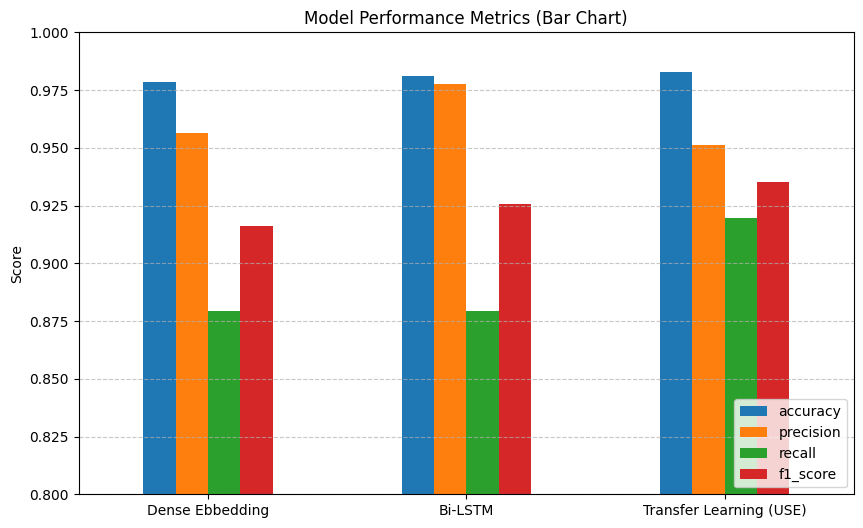

In [37]:
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Metrics (Bar Chart)")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

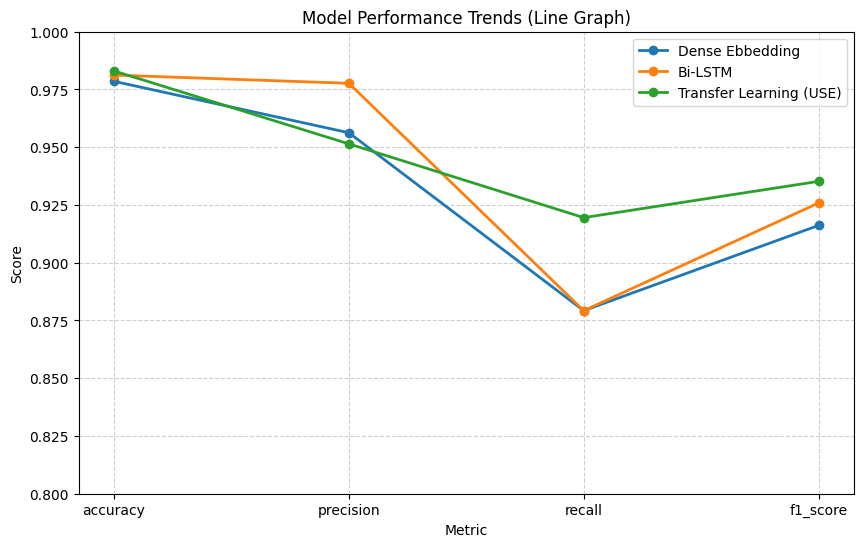

In [38]:
plt.figure(figsize=(10, 6))

for model_name in results_df.index:
    plt.plot(
        results_df.columns,
        results_df.loc[model_name],
        marker='o',
        label=model_name,
        linewidth=2
    )
plt.title("Model Performance Trends (Line Graph)")
plt.ylabel("Score")
plt.xlabel('Metric')
plt.ylim(0.8, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()